In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from functools import reduce
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
import os
from sklearn import tree
from sklearn.metrics import mean_squared_error 
from dtreeviz.trees import dtreeviz 
from  matplotlib.cm import ScalarMappable
import warnings
warnings.filterwarnings('ignore')

In [13]:
# simulation location data - X, Y, SimUID
loc = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt", sep = ",")

# simulation units, all climate, site data, principle components (PCA needs to be deleted) YEAR IS SEPARATE
obs_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUxYR_clim_clust.csv").drop(['Unnamed: 0','comp1','comp2', 'comp3', 'comp4', 'comp5', 'comp6', 'comp7', 'comp8', 'comp9',
       'comp10', 'k_mean_cluster'], axis = 1)

# simulation units, all climate in the format variable x month x year 
clim = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimU_plus_clim.csv")

# Corn x BAU x R00 monthly data
c_bau_r00 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_BAU_R00_monthly_data.csv")

# # climate PCA and clusters by SimUID
# clim_pca = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimU_all_pts_w_clim_pca_clust.csv")

# simUID site data
site_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUID_List.txt", sep = ";")


In [149]:
mean_yield = c_bau_r00[c_bau_r00.YR > 1985].groupby('SimUID').mean()
stdv_yield = c_bau_r00[c_bau_r00.YR > 1985].groupby('SimUID').std()

In [160]:
# merge site data to mean yield, stdv yield, and cluster 
m1 = pd.merge(site_df, mean_yield['YLDG'], how = "inner", on = "SimUID")
m2 = pd.merge(m1, stdv_yield['YLDG'], how = "inner", on = "SimUID")
c_df = pd.merge(m2, simU_clim_proj[['k_mean_cluster', 'SimUID']], how = "inner", on = "SimUID")

In [162]:
# upper and lower YLDG bounds by adding and subtracting one standard deviation 
c_df['YLDG_upper'] = c_df.YLDG_x + c_df.YLDG_y
c_df['YLDG_lower'] = c_df.YLDG_x - c_df.YLDG_y

In [165]:
c_df.columns

Index(['SimUID', 'SimU', 'NUTS2', 'LCF3', 'HRU', 'ELEV_CAT', 'SLP_CAT',
       'TEXTURE', 'DTR', 'STONES', 'ELEV', 'SLP_PRC', 'OC_TOP', 'SAND_TOP',
       'SAND_SUB', 'SILT_TOP', 'SILT_SUB', 'CLAY_TOP', 'CLAY_SUB', 'BD_TOP',
       'BD_SUB', 'BS_TOP', 'BS_SUB', 'CEC_TOP', 'CEC_SUB', 'SOB_TOP',
       'SOB_SUB', 'PH_TOP', 'PH_SUB', 'VS_TOP', 'VS_SUB', 'KS_TOP2', 'KS_SUB2',
       'WP_TOP', 'WP_SUB', 'FWC_TOP', 'FWC_SUB', 'TOPL', 'SUBL', 'HSG2',
       'YLDG_x', 'YLDG_y', 'k_mean_cluster', 'YLDG_upper', 'YLDG_lower'],
      dtype='object')

## PCA cluster by climate only - just to reduce dimensionality of climate data 

In [14]:
# PCA ANALYSIS
def PCA_fxn(df_full, cols):
    # pull variables to use for PCA
    df = df_full[cols].dropna()

    # instantiate scaler
    scaler = StandardScaler()
    # fit and transform data 
    scaled_df = scaler.fit_transform(df)
    scaled_features_df = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)
    
    # instantiate PCA 
    pca = PCA(n_components = .90)
    # fit to scaled data
    pca.fit(scaled_df)
    # projected data 
    projected = pca.transform(scaled_df)
        
    # return explained variance ratio and components
    return (projected, pca.explained_variance_ratio_, pca.components_, pca.explained_variance_, pca.n_components_)

In [5]:
# to look at the drop off in variance explained by components
def scree_plot(name, n_components_, explained_variance_ratio_): 
    PC_values = np.arange(n_components_) + 1
    plt.plot(PC_values, explained_variance_ratio_, 'o-', linewidth=1, color='blue')
    plt.title('Scree Plot ' + name)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//" + name + "_scree.jpg")
    plt.close()

In [15]:
#### RUN PCA FOR CLIMATE DATA ####

# pull climate variables from obs_df
clim_vars = ["PET", "PRCP", "RAD", "RAD", "TMN", "TMX","VPD"]
clim_cols = [col for col in clim.columns if any(var in col for var in clim_vars)]

# run PCA 
project_clim, var_ratio_clim, component_clim, var_clim, n_clim = PCA_fxn(clim, clim_cols)

# create component column names 
comp_cols = [("clim_comp" + str(i+1)) for i in range(n_clim)]

# save projected PCA data, pull back SimUID from original dataframe
projected_clim_df = pd.DataFrame(project_clim[:, :], columns = comp_cols)
ids = clim.dropna()
simU_clim_proj = pd.concat([ids['SimUID'].reset_index(drop=True),projected_clim_df.reset_index(drop=True)], axis=1)

# run scree plot 
# scree_plot("climate", n_clim, var_ratio_clim)

In [7]:
def test_kclusters(df_in, name): 
    # metrics to save 
    inertia = []
    CHS = []
    DBS = []
    
    df = df_in.drop("SimUID", axis = 1)
    
    # compute clusters for n = 4 - 12
    for i in range(4,11): 
        
        print (i, " kmeans started.")
        kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
        kmeans_pca.fit(df)
        
        print (i, " k means fitted.")
        
        # save metrics
        inertia.append(kmeans_pca.inertia_)
        CHS.append(sklearn.metrics.calinski_harabasz_score(df, kmeans_pca.labels_))
        DBS.append(sklearn.metrics.davies_bouldin_score(df, kmeans_pca.labels_))
        
        # update user
        print (name, " ", i, " metrics done.")
        
    # plot for data cluster performance 
    output = "//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//cluster_perf_" + name + ".jpg"
    
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    axs[0].plot(range(4,11), inertia, marker = "o", linestyle = '--')
    axs[0].set_title('K vs Inertia')
    
    axs[1].plot(range(4,11), CHS, marker = "o", linestyle = '--')
    axs[1].set_title('K vs Calinski-Harbabasz Score')
    
    axs[2].plot(range(4,11), DBS, marker = "o", linestyle = '--')
    axs[2].set_title('K vs Davies-Bouldin Score')
    
    plt.xlabel("k number of clusters")
    plt.ylabel("Score")
    plt.suptitle("K-Means Clustering Performance")
    plt.savefig(output)
    plt.close()
    
    # update user
    print (name, " ", i, " done.")
    
    return (inertia, CHS, DBS)

In [119]:
inertia, CHS, DBS = test_kclusters(simU_clim_proj, "climate")

4  kmeans started.
4  k means fitted.
climate   4  metrics done.
5  kmeans started.
5  k means fitted.
climate   5  metrics done.
6  kmeans started.
6  k means fitted.
climate   6  metrics done.
7  kmeans started.
7  k means fitted.
climate   7  metrics done.
8  kmeans started.
8  k means fitted.
climate   8  metrics done.
9  kmeans started.
9  k means fitted.
climate   9  metrics done.
10  kmeans started.
10  k means fitted.
climate   10  metrics done.
climate   10  done.


In [16]:
#### ONCE WE KNOW OPTIMAL K, COMPLETE AND SAVE CLUSTERS ####

# only feed PCA columns into clustering
cluster_input = simU_clim_proj.drop("SimUID", axis = 1)

# complete clusters 
k = 8
kmeans_pca = KMeans(n_clusters = k, init = "k-means++", random_state = 42)
kmeans_pca.fit(cluster_input)
print ("fitted.")

# add cluster label 
simU_clim_proj["k_mean_cluster"] = kmeans_pca.labels_

# dataset with all simulation unit information including geospatial info 
# output = pd.merge(full_df, SimU_loc, how = "inner", left_on = "SimUID", right_on = "SimUID")

fitted.


In [17]:
simU_clim_proj.to_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//climate_PCA_x_simUID.csv")

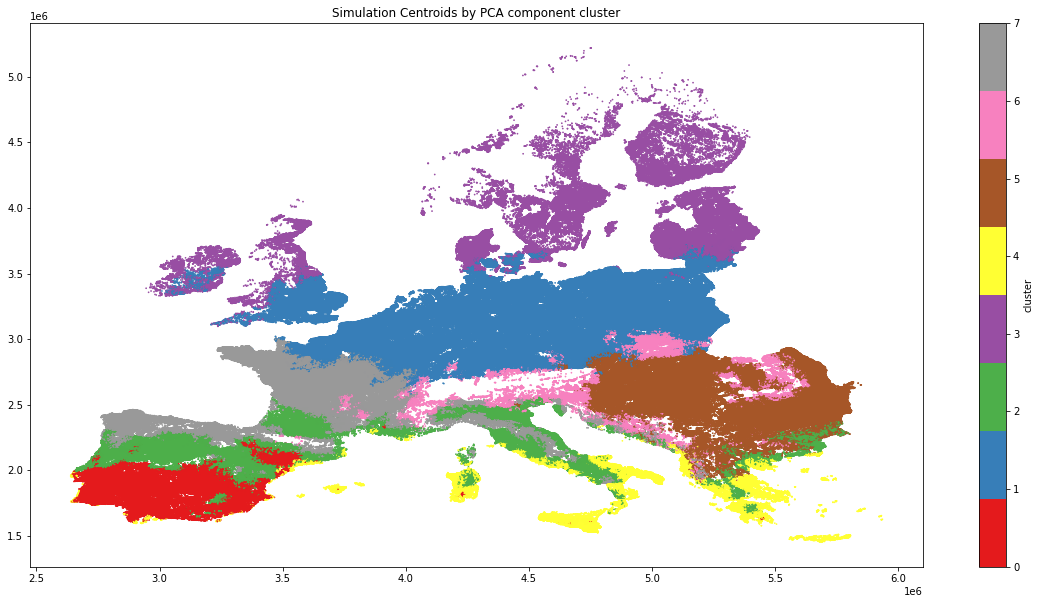

In [28]:
## PLOT PCA CLUSTERS 
output = pd.merge(simU_clim_proj, loc, how = "inner", left_on = "SimUID", right_on = "SimUID")
title = "Simulation Centroids by PCA component cluster"
cmap = matplotlib.cm.get_cmap("Set1", 8)
plt.figure(figsize = (20,10))
plt.scatter(output['X'], output["Y"], s= .5, c = output.k_mean_cluster ,cmap = cmap, edgecolor = None, alpha = 1)
plt.title(title)
plt.colorbar(ticks=range(8), label='cluster')
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimU_by_PCA_clim_clust.jpg")

## Then investigate clusters and see if they're representative of climate regime 

In [31]:
# pull climate variables from obs_df
clim_vars = ["PET", "PRCP", "RAD", "RAD", "TMN", "TMX","VPD"]
clim_cols = [col for col in obs_df.columns if any(var in col for var in clim_vars)]
clim_cols.append('YR')
clim_cols.append('SimUID')
clim_obs = obs_df[clim_cols]

# attach clusters to clim_obs
clim_clust = pd.merge(clim_obs, simU_clim_proj[['SimUID', 'k_mean_cluster']], how = "left", on = "SimUID")

In [32]:
# for each variiable, get the maximum and minimum monthly value of all points in all years 
def get_min_max(df, var, cluster):
    # pull variable columns
    cols = [col for col in df.columns if var in col]
    months =['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    # store monthly minimum and maximum 
    var_min = []
    var_max = []
    var_mean = []
    var_std = []
    
    # separate the dataframe by cluster then by variable
    clust_df = df[df.k_mean_cluster == cluster]
    var_df = clust_df[cols]
    
    # loop over the months to get minimum and maximum for each month 
    for m in months: 
        m_col = [col for col in cols if m in col][0]
        var_min.append(var_df[m_col].min())
        var_max.append(var_df[m_col].max())
        var_mean.append(var_df[m_col].mean())
        var_std.append(var_df[m_col].std())
    
    return(var_min, var_max, var_mean, var_std)

In [33]:
#### PULL MINIMUMS AND MAXIMUMS FOR EACH VARIABLE FOR EACH MONTH IN EACH CLUSTER #### 

cluster_mins = {}
cluster_maxs = {}
cluster_means = {}
cluster_stds = {}
cluster_std_above = {}
cluster_std_below = {}

in_df = clim_clust
# for each climate variable, loop over the clusters to pull statistics 
for var in clim_vars:
    print (var, " started.")
    # each entry in these lists is a cluster specific list of mins for a given variable
    var_min_list = []
    var_max_list = []
    var_mean_list = []
    var_std_list = []
    var_std_above = []
    var_std_below = []
    
    for c in set(clim_clust.k_mean_cluster.unique()):
        # run the function
        mins, maxs, means, stds = get_min_max(in_df, var, c)
        var_min_list.append(mins)
        var_max_list.append(maxs)
        var_mean_list.append(means)
        var_std_list.append(stds)
        var_std_above.append(list(np.asarray(means) + np.asarray(stds)))
        var_std_below.append(list(np.asarray(means) - np.asarray(stds)))
        print (c, " cluster done.")
        
    # then save to dictionary 
    cluster_mins[var] = var_min_list
    cluster_maxs[var] = var_max_list
    cluster_means[var] = var_mean_list
    cluster_stds[var] = var_std_list
    cluster_std_above[var] = var_std_above
    cluster_std_below[var] = var_std_below
    
    print (var, " done.")

PET  started.
0  cluster done.
1  cluster done.
2  cluster done.
3  cluster done.
4  cluster done.
5  cluster done.
6  cluster done.
7  cluster done.
PET  done.
PRCP  started.
0  cluster done.
1  cluster done.
2  cluster done.
3  cluster done.
4  cluster done.
5  cluster done.
6  cluster done.
7  cluster done.
PRCP  done.
RAD  started.
0  cluster done.
1  cluster done.
2  cluster done.
3  cluster done.
4  cluster done.
5  cluster done.
6  cluster done.
7  cluster done.
RAD  done.
RAD  started.
0  cluster done.
1  cluster done.
2  cluster done.
3  cluster done.
4  cluster done.
5  cluster done.
6  cluster done.
7  cluster done.
RAD  done.
TMN  started.
0  cluster done.
1  cluster done.
2  cluster done.
3  cluster done.
4  cluster done.
5  cluster done.
6  cluster done.
7  cluster done.
TMN  done.
TMX  started.
0  cluster done.
1  cluster done.
2  cluster done.
3  cluster done.
4  cluster done.
5  cluster done.
6  cluster done.
7  cluster done.
TMX  done.
VPD  started.
0  cluster done.
1

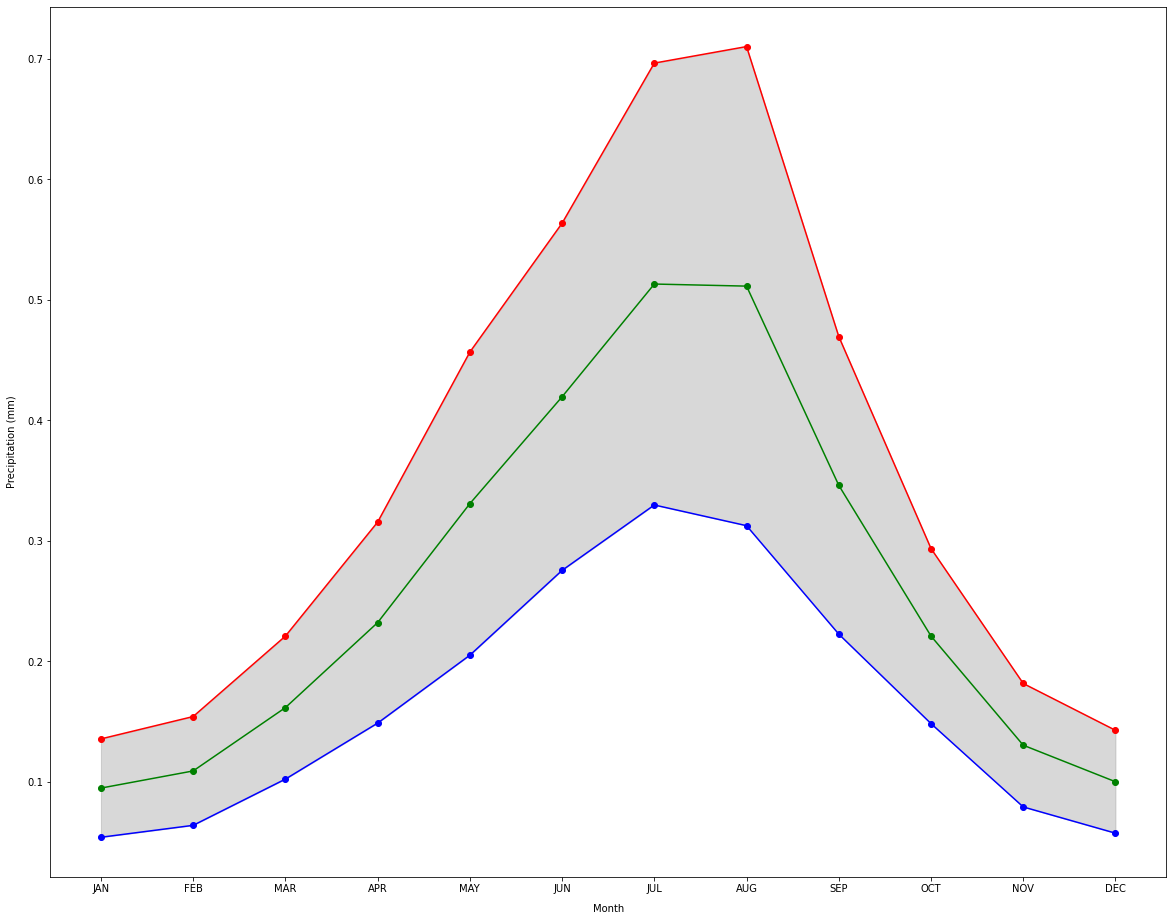

In [122]:
#### LOOK AT VARIABLE BANDS FOR EACH CLIMATE VARIABLE, CLUSTER #### 
months =['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

cluster = 0
var = 'VPD'
x = range(1,13)
plt.figure(figsize = (20,16))
plt.plot(x, cluster_std_above[var][cluster], color = 'red', marker = 'o')
plt.plot(x, cluster_std_below[var][cluster], color = 'blue', marker = 'o')
plt.plot(x, cluster_means[var][cluster], color = 'green', marker = 'o')
plt.fill_between(x, cluster_std_above[var][cluster], cluster_std_below[var][cluster], color = 'grey', alpha = .3)
plt.xticks(x, labels = months)
plt.xlabel("Month", labelpad = 10)
plt.ylabel("Precipitation (mm)", labelpad = 10)
plt.show()

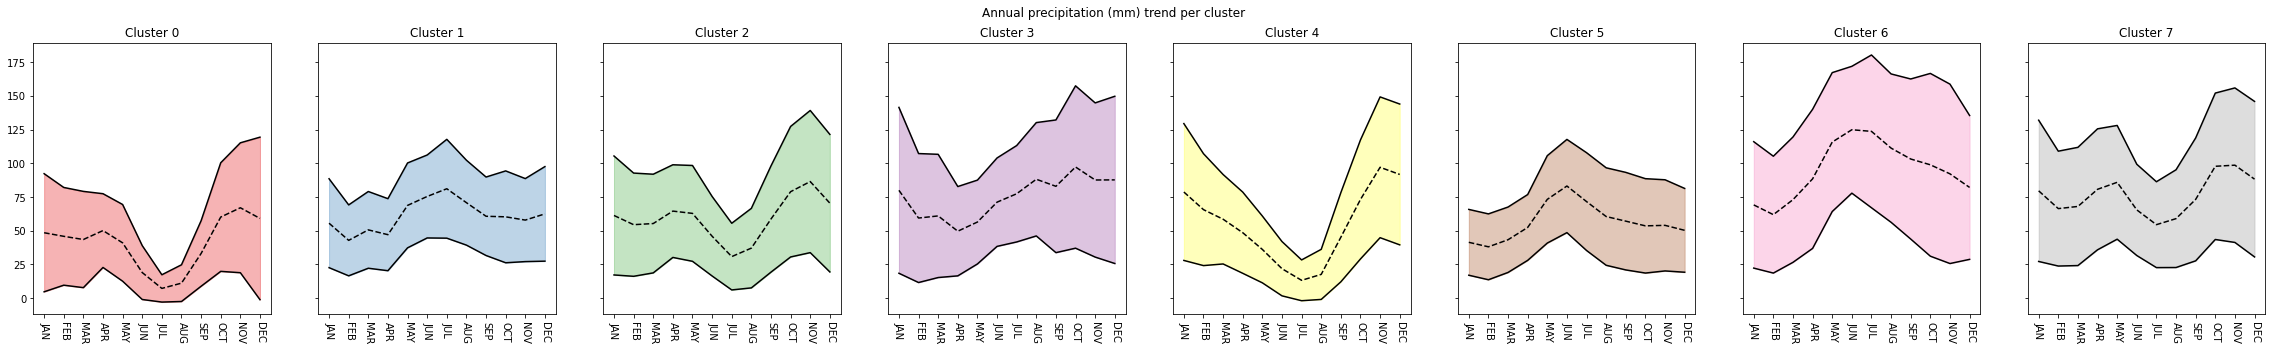

In [41]:
# rows = variables, columns = clusters 
cols = 8
rows = 1
# climate variables
clim_vars = ["PET", "PRCP", "RAD", "TMN", "TMX","VPD"]
# months 
months =['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
cmap = matplotlib.cm.get_cmap("Set1", 8)

# make subplots 
fig, axs = plt.subplots(rows, cols, figsize=(40,5), sharex = True, sharey = True)
fig.suptitle("Annual precipitation (mm) trend per cluster")

var = "PRCP"
for c in range(cols): 
    axs[c].plot(range(1,13), cluster_std_above[var][c], color = 'black')
    axs[c].plot(range(1,13), cluster_std_below[var][c], color = 'black')
    axs[c].plot(range(1,13), cluster_means[var][c], color = 'black', linestyle = '--')
    axs[c].fill_between(range(1,13), cluster_std_above[var][c], cluster_std_below[var][c], color = cmap(c), alpha = .33)
    axs[c].set_title("Cluster " + str(c))
    axs[c].set_xticks(range(1,13))
    axs[c].set_xticklabels(months, rotation = 270)
    
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//Cluster_clim_regime.jpg")



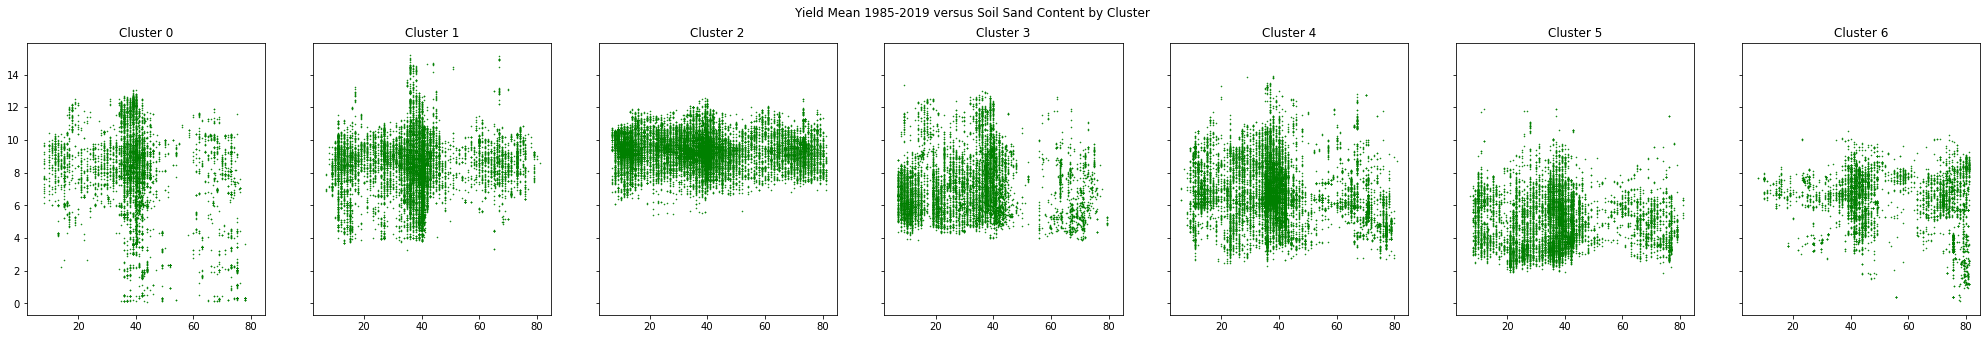

In [174]:
#### NOW LOOK AT RESPONSE DYNAMICS ####

# for each climate cluster, look at the response between soil sand content and yield 
# average yield over all years for each simUID 
 
# columns = clusters 
cols = 7

# make subplots 
fig, axs = plt.subplots(rows, cols, figsize=(35,5), sharex = True, sharey = True)
fig.suptitle("Yield Mean 1985-2019 versus Soil Sand Content by Cluster")

x_var = "SAND_TOP"
for c in range(cols): 
#     axs[c].scatter(c_df[c_df.k_mean_cluster == c][x_var], c_df[c_df.k_mean_cluster == c]["YLDG_upper"], color = 'red')
#     axs[c].scatter(c_df[c_df.k_mean_cluster == c][x_var], c_df[c_df.k_mean_cluster == c]["YLDG_lower"], color = 'blue')
    axs[c].scatter(c_df[c_df.k_mean_cluster == c][x_var], c_df[c_df.k_mean_cluster == c]["YLDG_x"], color = 'green', s = .3)
#     axs[c].fill_between(c_df[c_df.k_mean_cluster == c][x_var], c_df[c_df.k_mean_cluster == c]["YLDG_upper"], c_df[c_df.k_mean_cluster == c]["YLDG_lower"], color = 'grey', alpha = .2)
    axs[c].set_title("Cluster " + str(c))
#     axs[c].set_xticks(range(1,13))
#     axs[c].set_xticklabels(months, rotation = 270)